# Authoritarianism and Domestic Policy Attitudes
### In the Western United States

Maya, these data are really close to the ANES, but they have some additional questions that would be of use. I recoded much of the data.

The data reported below are from the 2020 Western States Survey, a collaborative project of researchers form the University of Arizona, Arizona State University, the University of Utah, University of New Mexico, the University of Colorado, and the University of Nevada. In 2020, we commissioned YouGov to interview 3,577 respondents, which were matched down to a sample of 3,000, the final dataset. The data include an oversample of 600 Latinos, due to the large Latino population in the western United States. Respondents were matched to a sampling frame based on gender, age, race, and education, using the full American Community Survey (ACS) 1-year sample. The matched cases were weighted by propensity scores, and sample weights were constructed based on the 2016 presidential vote, age, gender, race, and education. 

This is how I load the data.


In [72]:
rm(list = ls())
library(dplyr)
library(rstan)
library(tidyr)
library(modelr)
library(brms)
library(tidybayes)
load("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/data/westernCleaned.rda")

zero.one <- function(x) {
  min.x <- min(x, na.rm = T)
  max.x <- max(x - min.x, na.rm = T)
  return((x - min.x) / max.x)
}
thesisData <- read.csv("thesisData.csv")


I created an authoritarianism score for every respondent using what's called an Item Response Theory model, known as a [Rasch Model](https://en.wikipedia.org/wiki/Rasch_model). I removed the details. It's not reallly important here, suffice it to say it is a statistical model to generate an authoritarianism score for each respondent.  The data that is analyzed is called "thesisData.csv" and is available in the data folder.



Here is the data to analyze. It's stored in the Dropbox folder, it's just a CSV file, which you can open in other programs, like Excel. Here are the first six rows.

In [149]:
## This is the data to analyze ##
head(thesisData)

,X,rid,mean,lower,upper,auth1,auth2,auth3,auth4,authoritarianism,...,rr,moral_individualism,individualism,ideology,gender,party3,caseid,age,gen,authScaled
,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<chr>,<dbl>
1,1,1237524981,0.1253095,-1.3842783,1.5730996,1,0,1,0,0.50,...,0.0000,0.9375,0.15,1,Female,1,1237524981,43,Gen X,0.50423685
2,2,1238623187,-0.4055693,-1.8384456,1.0395513,0,0,0,1,0.25,...,0.6875,0.2500,0.45,2,Female,1,1238623187,53,Gen X,0.27572721
3,3,1239703947,-0.9952612,-2.6596056,0.5228655,0,0,0,0,0.00,...,0.0625,0.1250,0.20,1,Male,NA,1239703947,73,Boomer,0.02190225
4,4,1241042843,-0.9984238,-2.5772409,0.5269997,0,0,0,0,0.00,...,0.1250,0.3750,0.40,4,Female,2,1241042843,65,Boomer,0.02054097
5,5,1247946517,0.6850764,-0.7559359,2.1946961,1,1,1,0,0.75,...,0.6250,0.3750,0.50,5,Male,3,1247946517,83,Greatest,0.74518101
6,6,1248601193,-1.0099308,-2.5966724,0.4714263,0,0,0,0,0.00,...,0.0000,0.6250,0.20,2,Female,1,1248601193,35,Millenial,0.01558793


I generated a statistical model known as a regression model. It's a way to estimate the relationship between a dependent variable and one or more independent variables. In this case, the dependent variable is the authoritarianism score, and the independent variables are the domestic policy attitudes. The model also controls for a number of demographic variables, like gender, race, hispanic/latino, education, and income. It also includes an interaction term between authoritarianism and latino, to see if the relationship between authoritarianism and domestic policy attitudes is different for Latinos. The model is:

$$
p(y_{i,policy} \leq  k) = Logit^{-1}(\tau_{j} + \beta_1 x_{i,authoritarianism} + \beta_2 x_{i,latino} + \beta_3 x_{i,authoritarianism} \times x_{i,latino} + \beta_4 x_{i, White} + \beta_5 x_{i, College} + \beta_6 x_{i, Income})) \
$$

If this is a little confusing -- perhaps because you've not seen something like this before -- don't get caught up in the details. Basically, I'll just use these to create figures and tables which make much more sense.


### Some Helper Function

Below are some helper functions. Sometimes when doing analysis it's useful to write functions that do some of the work for you, particularly if it's a repetitive task and you'd otherwise just be cutting and pasting the same set of code chunks. This can make the code easier to read and understand.

In [121]:
## Fit a bayesian ordinal model #
fit_model <- function(formula, data) {
  model <- brm(
    formula = formula,
    data = data,
    family = cumulative(),
    chains = 2,
    cores = 6,
    seed = 1234,
    iter = 4000
  )
  return(model)
}

## Generate a formula for the model ##
generate_formula <- function(DV) {
  form <- bf(
    as.formula(paste(DV, "~ gender + other + black + latino + college + income + gen + authScaled + authScaled:latino"))
  )
  return(form)
}

## Themes for the plots ##
ggtheme <- theme(
  plot.title = element_text(face = "bold", hjust = 0, vjust = 0, colour = "#3C3C3C", size = 20),
  axis.text.x = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.text.y = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.title = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.title.y = element_text(size = 16, colour = "#535353", face = "bold", vjust = 1.5),
  axis.ticks = element_blank(),
  strip.text.x = element_text(size = 16),
  panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
  panel.background = element_rect(fill = "white"),
  legend.text = element_text(size = 14),
  legend.title = element_text(size = 16)
)

## Generate a GGPLOT
createPlot <- function(data = thesisData, model = registry, title = "Create a National Gun Registry") {
  data %>%
    data_grid(
      gender = c("Male", "Female"), white = c(0,1), other = 0, black = 0,
      college = mean(college), income = mean(income),
      gen = c("Greatest", "Boomer", "Gen X", "Millenial"),
      latino = c(0, 1), authScaled = seq_range(authScaled, n = 2)
    ) %>%
    add_epred_draws(model) %>%
    mutate(.category = case_when(
      .category %in% c(1, 2) ~ "Oppose",
      .category == 3 ~ "Neutral",
      .category %in% c(4, 5) ~ "Support",
      TRUE ~ "NA"
    )) %>%
    group_by(.category, authScaled, latino) %>%
    mutate(latino = ifelse(latino == 0, "Non Hispanic White", "Latino")) %>%
        # Compare Two Groups

        filter(latino == "Latino" | white == 1) %>%

    summarize(mean = mean(.epred), lower = quantile(.epred, 0.025), upper = quantile(.epred, 0.975)) %>%

        mutate(authScaled = ifelse(authScaled == 0, "Non-Authoritarian", "Authoritarian")) %>%

        #Reorder the category response
        mutate(.category = factor(.category, levels = c("Oppose", "Neutral", "Support"))) %>%

        # Neatly print the tibble passed to the ggplot
        print() %>%

    ggplot(aes(
      x = authScaled,
      group = .category,
      color = .category,
      y = mean,
      ymin = lower,
      ymax = upper
    )) +
    facet_wrap(~latino, nrow = 3) +
    geom_point(size = 6, alpha = 0.75, position = position_dodge(width = 0.5)) +
    geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
    # Format the grid
    ggtitle(title) +
    scale_y_continuous("Probability", limits = c(0, 1)) +
    scale_x_discrete("Authoritarianism") +
    scale_colour_manual(name = "Response", values = c("darkgrey", "#908e8e", "black")) +
    ggtheme +
    # Flip
    coord_flip()
}


Basically, below runs five regression models. Each regression model is known as an "ordered logit" -- what I'm generally doing is predicting the probability of being in the $j$ th category for each item. The model is a little complex, but the predictions are easy to interpret. There are five questions:


* Grant legal status to undocumneted immigratns who have held jobs and paid taxes for at least three years, and not been convicted of any felony crimes (immUndocumented)
* End the separation of children and parents at the border (immSeparation)
* Reduce nuymber of asylum seekers  (immAsylum)
* Support ending birthright citizenship (immBirthright)
* Increase smart technology at the border (immTech)

Before analyzing the data, I recoded these variables (similar to what you did in your recodes), such that high scores is the more anti-immigration position. 



In [ ]:
# Suppress sampling messages

documented <- fit_model(generate_formula(DV = "immUndocumented"), thesisData)
separation <- fit_model(generate_formula(DV = "immSeparation"), thesisData)
asylum <- fit_model(generate_formula(DV = "immAsylum"), thesisData)
birthright <- fit_model(generate_formula(DV = "immBirthright"), thesisData)
technology <- fit_model(generate_formula(DV = "immTech"), thesisData)

In [ ]:
concealCarry <- fit_model(generate_formula(DV = "concealCarry"), thesisData)
background <- fit_model(generate_formula(DV = "background"), thesisData)
registry <- fit_model(generate_formula(DV = "registry"), thesisData)

In [ ]:
waterConservation <- fit_model(generate_formula(DV = "concealCarry"), thesisData)
waterDams <- fit_model(generate_formula(DV = "waterDams"), thesisData)

I also estimated the model on attitudes towards Gun Control. The questions are:

* Make it easier to obtain concealed carry permits (concealCarry)
* Create a national gun registry (registry)
* Mandate background checks for all gun purchases (background)


I also estimated the model on attitudes towards the environment. The questions are:

* Require mandatory water conservation (waterConservation)
* Build infrastrucutre and dams to increase water supply (waterDams)

Let's see how authoritarianism is expressed across latino and non-latino populations in the Western United States.

`summarise()` has grouped output by '.category', 'authScaled'. You can override
using the `.groups` argument.


# A tibble: 12 x 6
# Groups:   .category, authScaled [6]
   .category authScaled        latino              mean  lower upper
   <fct>     <chr>             <chr>              <dbl>  <dbl> <dbl>
 1 Neutral   Non-Authoritarian Latino             0.160 0.112  0.207
 2 Neutral   Non-Authoritarian Non Hispanic White 0.163 0.118  0.208
 3 Neutral   Authoritarian     Latino             0.185 0.148  0.215
 4 Neutral   Authoritarian     Non Hispanic White 0.195 0.157  0.216
 5 Oppose    Non-Authoritarian Latino             0.319 0.143  0.620
 6 Oppose    Non-Authoritarian Non Hispanic White 0.313 0.147  0.602
 7 Oppose    Authoritarian     Latino             0.265 0.140  0.505
 8 Oppose    Authoritarian     Non Hispanic White 0.173 0.0882 0.317
 9 Support   Non-Authoritarian Latino             0.102 0.0495 0.209
10 Support   Non-Authoritarian Non Hispanic White 0.106 0.0526 0.217
11 Support   Authoritarian     Latino             0.143 0.0711 0.294
12 Support   Authoritarian     Non Hispanic Wh

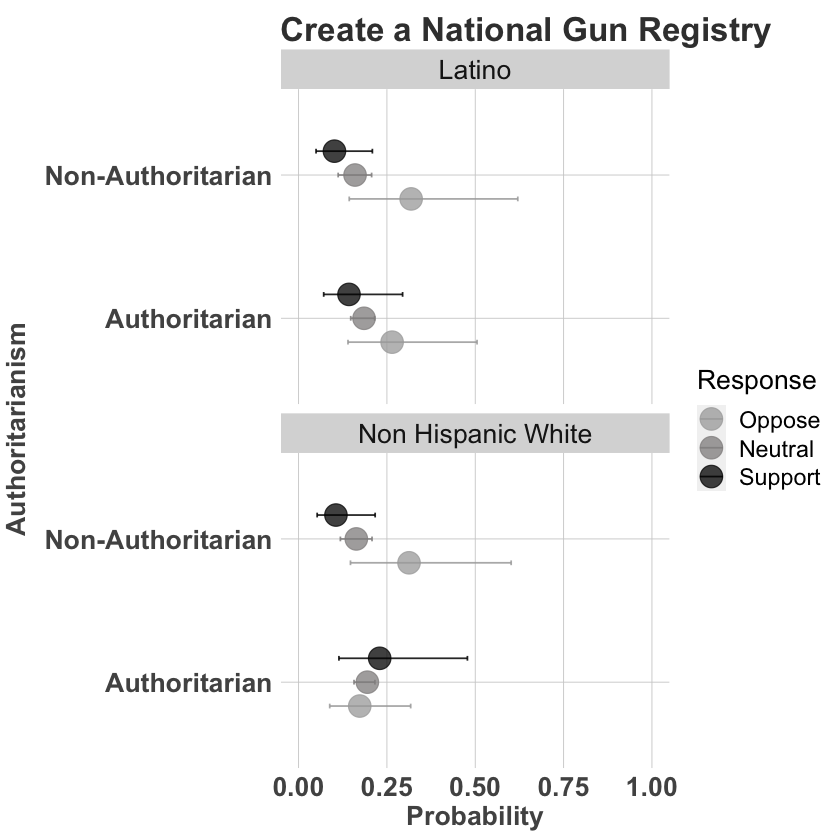

In [122]:
createPlot()
# Save plot
ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/registry.png", width = 8, height = 8, dpi = 300)


`summarise()` has grouped output by '.category', 'authScaled'. You can override
using the `.groups` argument.


# A tibble: 12 x 6
# Groups:   .category, authScaled [6]
   .category authScaled        latino               mean  lower upper
   <fct>     <chr>             <chr>               <dbl>  <dbl> <dbl>
 1 Neutral   Non-Authoritarian Latino             0.217  0.159  0.258
 2 Neutral   Non-Authoritarian Non Hispanic White 0.208  0.148  0.253
 3 Neutral   Authoritarian     Latino             0.245  0.215  0.265
 4 Neutral   Authoritarian     Non Hispanic White 0.226  0.177  0.261
 5 Oppose    Non-Authoritarian Latino             0.282  0.190  0.485
 6 Oppose    Non-Authoritarian Non Hispanic White 0.296  0.195  0.511
 7 Oppose    Authoritarian     Latino             0.165  0.0999 0.258
 8 Oppose    Authoritarian     Non Hispanic White 0.121  0.0672 0.187
 9 Support   Non-Authoritarian Latino             0.110  0.0543 0.172
10 Support   Non-Authoritarian Non Hispanic White 0.0997 0.0491 0.159
11 Support   Authoritarian     Latino             0.213  0.133  0.328
12 Support   Authoritarian     No

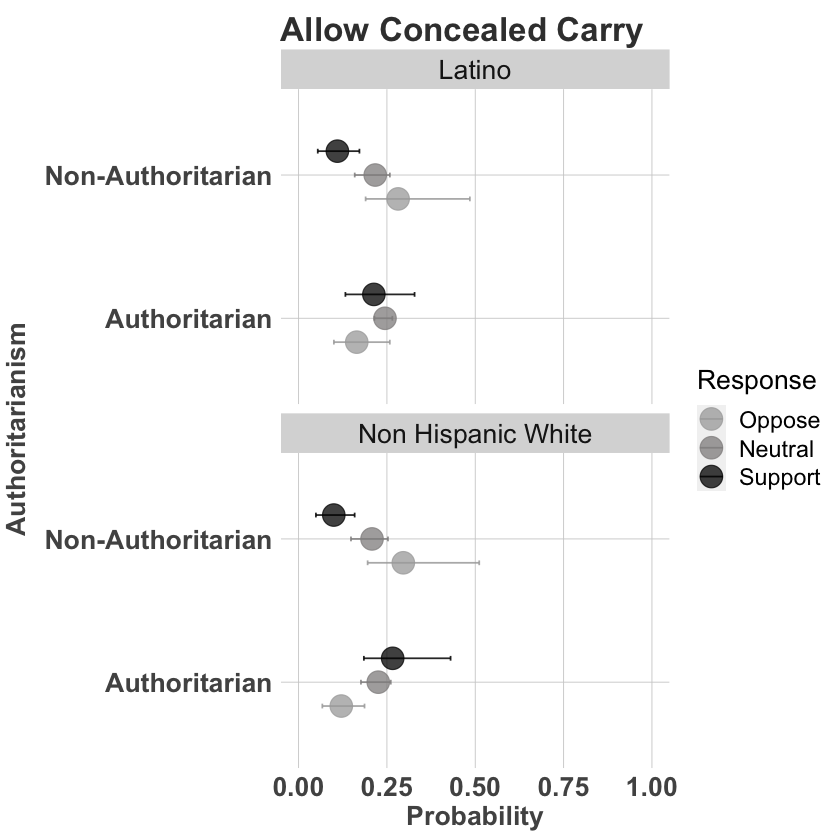

In [123]:
createPlot(thesisData, concealCarry, "Allow Concealed Carry")
ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/concealCarry.png", width = 8, height = 8, dpi = 300)


`summarise()` has grouped output by '.category', 'authScaled'. You can override
using the `.groups` argument.


# A tibble: 12 x 6
# Groups:   .category, authScaled [6]
   .category authScaled        latino               mean  lower upper
   <fct>     <chr>             <chr>               <dbl>  <dbl> <dbl>
 1 Neutral   Non-Authoritarian Latino             0.107  0.0652 0.155
 2 Neutral   Non-Authoritarian Non Hispanic White 0.114  0.0715 0.160
 3 Neutral   Authoritarian     Latino             0.171  0.132  0.198
 4 Neutral   Authoritarian     Non Hispanic White 0.180  0.148  0.201
 5 Oppose    Non-Authoritarian Latino             0.385  0.196  0.666
 6 Oppose    Non-Authoritarian Non Hispanic White 0.376  0.206  0.642
 7 Oppose    Authoritarian     Latino             0.275  0.182  0.415
 8 Oppose    Authoritarian     Non Hispanic White 0.163  0.0806 0.248
 9 Support   Non-Authoritarian Latino             0.0617 0.0307 0.113
10 Support   Non-Authoritarian Non Hispanic White 0.0672 0.0338 0.121
11 Support   Authoritarian     Latino             0.140  0.0719 0.261
12 Support   Authoritarian     No

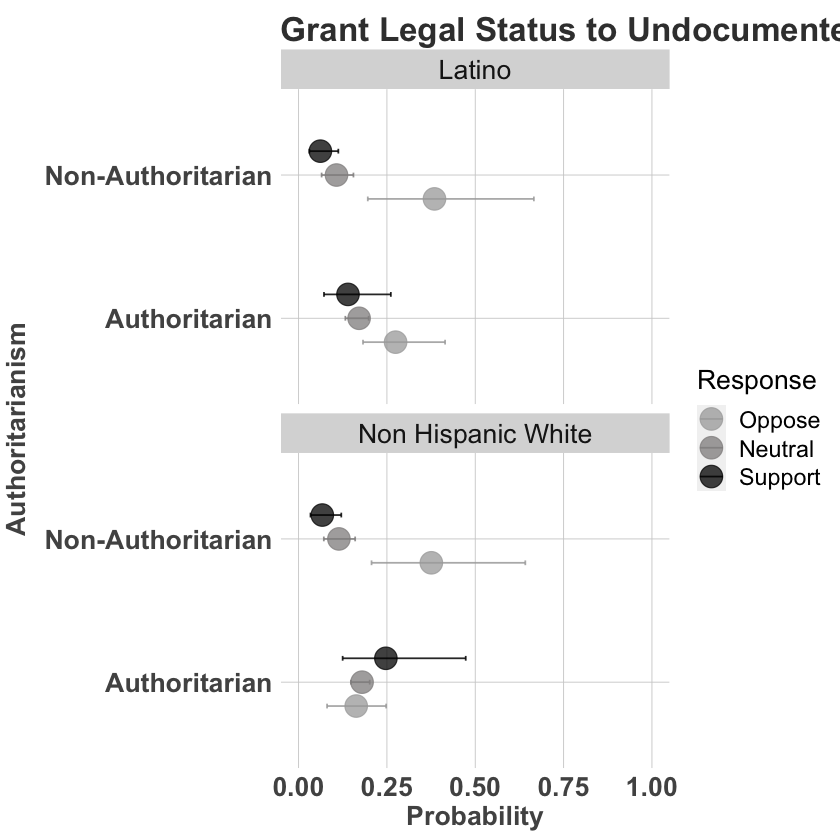

In [124]:
createPlot(thesisData, documented, "Grant Legal Status to Undocumented Workers")
ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/imm1.png", width = 8, height = 8, dpi = 300)


`summarise()` has grouped output by '.category', 'authScaled'. You can override
using the `.groups` argument.


# A tibble: 12 x 6
# Groups:   .category, authScaled [6]
   .category authScaled        latino               mean  lower  upper
   <fct>     <chr>             <chr>               <dbl>  <dbl>  <dbl>
 1 Neutral   Non-Authoritarian Latino             0.129  0.0793 0.207 
 2 Neutral   Non-Authoritarian Non Hispanic White 0.120  0.0746 0.194 
 3 Neutral   Authoritarian     Latino             0.239  0.189  0.281 
 4 Neutral   Authoritarian     Non Hispanic White 0.264  0.235  0.289 
 5 Oppose    Non-Authoritarian Latino             0.395  0.0888 0.780 
 6 Oppose    Non-Authoritarian Non Hispanic White 0.403  0.0842 0.794 
 7 Oppose    Authoritarian     Latino             0.267  0.132  0.509 
 8 Oppose    Authoritarian     Non Hispanic White 0.203  0.102  0.377 
 9 Support   Non-Authoritarian Latino             0.0406 0.0205 0.0813
10 Support   Non-Authoritarian Non Hispanic White 0.0368 0.0190 0.0730
11 Support   Authoritarian     Latino             0.113  0.0597 0.228 
12 Support   Authori

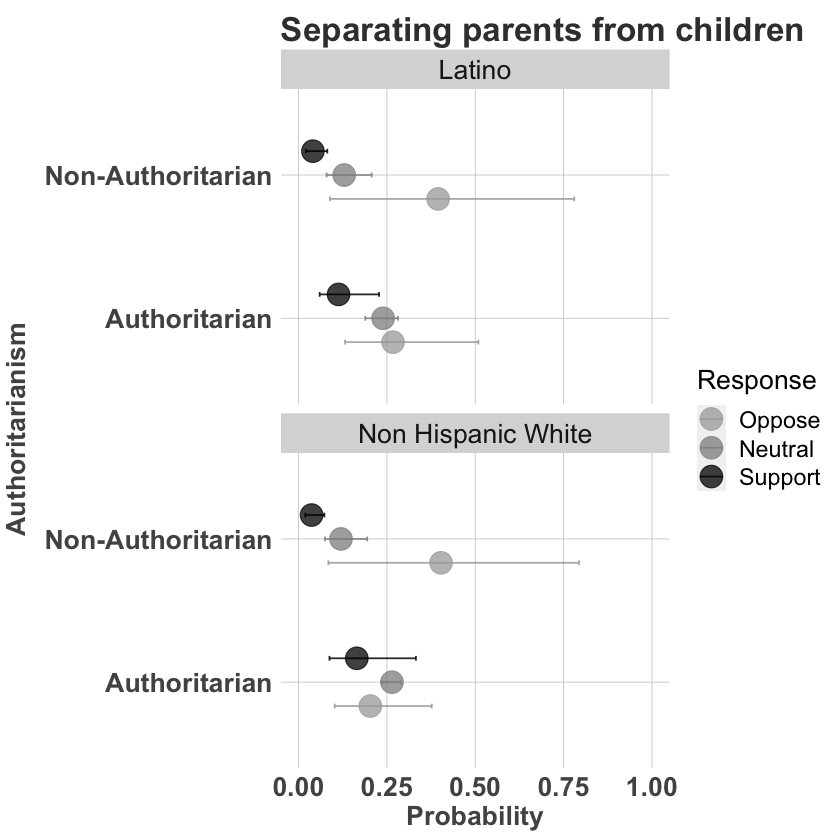

In [127]:
createPlot(thesisData, separation, "Separating parents from children")
ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/imm2.png", width = 8, height = 8, dpi = 300)


`summarise()` has grouped output by '.category', 'authScaled'. You can override
using the `.groups` argument.


# A tibble: 12 x 6
# Groups:   .category, authScaled [6]
   .category authScaled        latino               mean  lower  upper
   <fct>     <chr>             <chr>               <dbl>  <dbl>  <dbl>
 1 Neutral   Non-Authoritarian Latino             0.268  0.215  0.301 
 2 Neutral   Non-Authoritarian Non Hispanic White 0.249  0.180  0.298 
 3 Neutral   Authoritarian     Latino             0.216  0.130  0.284 
 4 Neutral   Authoritarian     Non Hispanic White 0.154  0.0800 0.234 
 5 Oppose    Non-Authoritarian Latino             0.225  0.128  0.396 
 6 Oppose    Non-Authoritarian Non Hispanic White 0.266  0.166  0.478 
 7 Oppose    Authoritarian     Latino             0.0803 0.0326 0.142 
 8 Oppose    Authoritarian     Non Hispanic White 0.0466 0.0177 0.0905
 9 Support   Non-Authoritarian Latino             0.141  0.0664 0.234 
10 Support   Non-Authoritarian Non Hispanic White 0.110  0.0483 0.190 
11 Support   Authoritarian     Latino             0.312  0.198  0.577 
12 Support   Authori

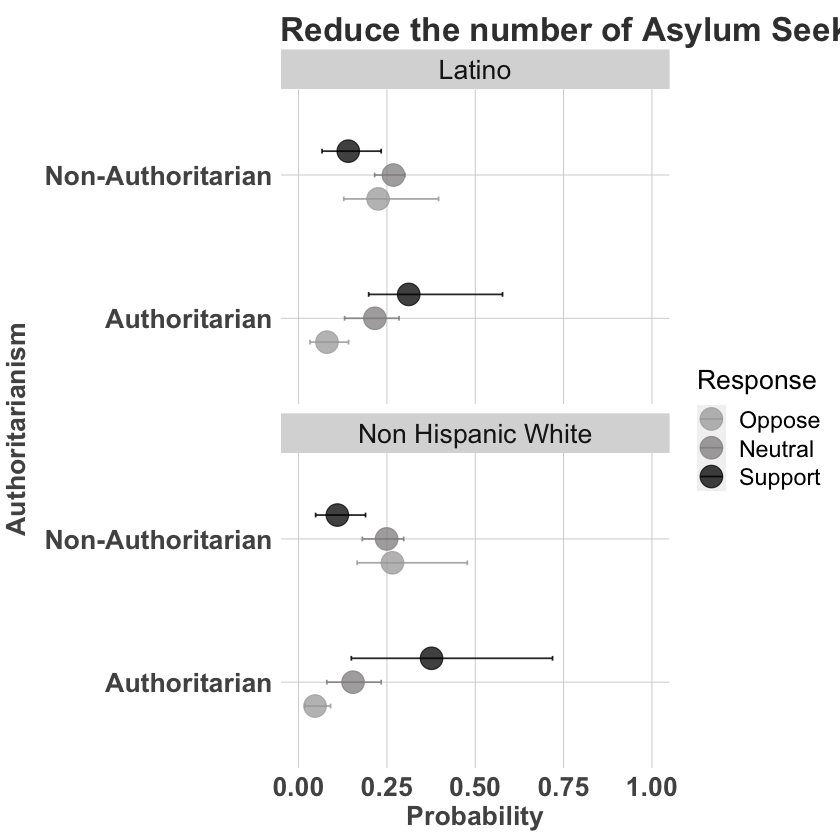

In [128]:
createPlot(thesisData, asylum, "Reduce the number of Asylum Seekers")
ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/imm3.png", width = 8, height = 8, dpi = 300)


`summarise()` has grouped output by '.category', 'authScaled'. You can override
using the `.groups` argument.


# A tibble: 12 x 6
# Groups:   .category, authScaled [6]
   .category authScaled        latino               mean  lower upper
   <fct>     <chr>             <chr>               <dbl>  <dbl> <dbl>
 1 Neutral   Non-Authoritarian Latino             0.133  0.0904 0.168
 2 Neutral   Non-Authoritarian Non Hispanic White 0.111  0.0651 0.161
 3 Neutral   Authoritarian     Latino             0.137  0.0703 0.171
 4 Neutral   Authoritarian     Non Hispanic White 0.0819 0.0265 0.133
 5 Oppose    Non-Authoritarian Latino             0.284  0.0811 0.653
 6 Oppose    Non-Authoritarian Non Hispanic White 0.342  0.0710 0.758
 7 Oppose    Authoritarian     Latino             0.155  0.0402 0.371
 8 Oppose    Authoritarian     Non Hispanic White 0.0626 0.0140 0.154
 9 Support   Non-Authoritarian Latino             0.149  0.0633 0.395
10 Support   Non-Authoritarian Non Hispanic White 0.103  0.0418 0.276
11 Support   Authoritarian     Latino             0.276  0.113  0.671
12 Support   Authoritarian     No

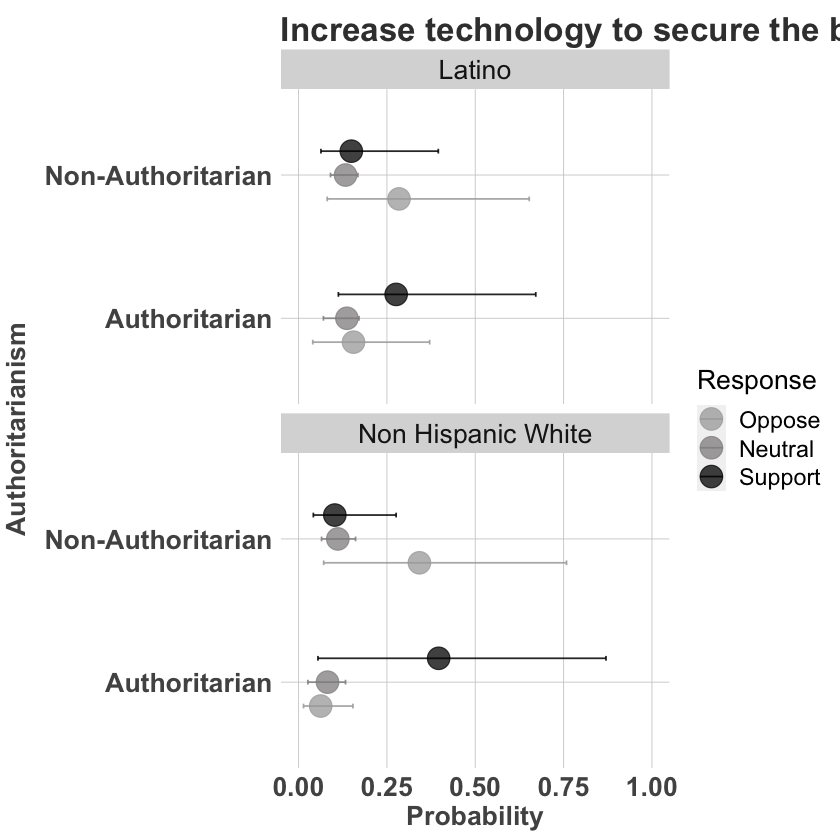

In [129]:
createPlot(thesisData, technology, "Increase technology to secure the border")
ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/imm4.png", width = 8, height = 8, dpi = 300)


`summarise()` has grouped output by '.category', 'authScaled'. You can override
using the `.groups` argument.


# A tibble: 12 x 6
# Groups:   .category, authScaled [6]
   .category authScaled        latino               mean  lower upper
   <fct>     <chr>             <chr>               <dbl>  <dbl> <dbl>
 1 Neutral   Non-Authoritarian Latino             0.217  0.159  0.258
 2 Neutral   Non-Authoritarian Non Hispanic White 0.208  0.148  0.253
 3 Neutral   Authoritarian     Latino             0.245  0.215  0.265
 4 Neutral   Authoritarian     Non Hispanic White 0.226  0.177  0.261
 5 Oppose    Non-Authoritarian Latino             0.282  0.190  0.485
 6 Oppose    Non-Authoritarian Non Hispanic White 0.296  0.195  0.511
 7 Oppose    Authoritarian     Latino             0.165  0.0999 0.258
 8 Oppose    Authoritarian     Non Hispanic White 0.121  0.0672 0.187
 9 Support   Non-Authoritarian Latino             0.110  0.0543 0.172
10 Support   Non-Authoritarian Non Hispanic White 0.0997 0.0491 0.159
11 Support   Authoritarian     Latino             0.213  0.133  0.328
12 Support   Authoritarian     No

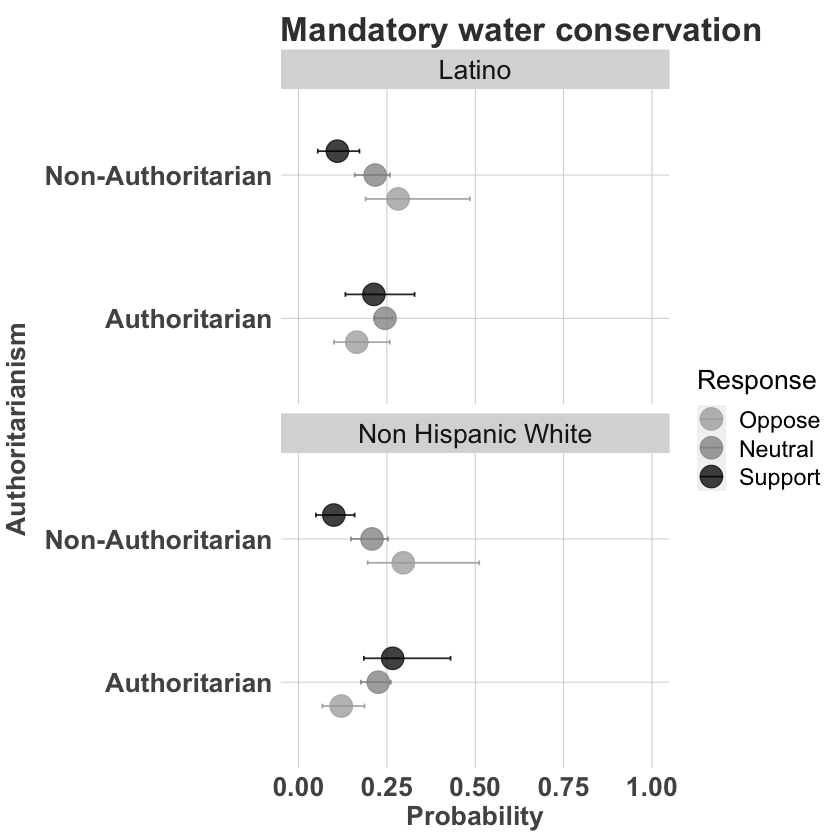

In [130]:
createPlot(thesisData, waterConservation, "Mandatory water conservation")
ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/water1.png", width = 8, height = 8, dpi = 300)


`summarise()` has grouped output by '.category', 'authScaled'. You can override
using the `.groups` argument.


# A tibble: 12 x 6
# Groups:   .category, authScaled [6]
   .category authScaled        latino               mean  lower  upper
   <fct>     <chr>             <chr>               <dbl>  <dbl>  <dbl>
 1 Neutral   Non-Authoritarian Latino             0.194  0.126  0.244 
 2 Neutral   Non-Authoritarian Non Hispanic White 0.206  0.138  0.253 
 3 Neutral   Authoritarian     Latino             0.193  0.126  0.242 
 4 Neutral   Authoritarian     Non Hispanic White 0.190  0.125  0.238 
 5 Oppose    Non-Authoritarian Latino             0.0348 0.0104 0.0694
 6 Oppose    Non-Authoritarian Non Hispanic White 0.0379 0.0115 0.0737
 7 Oppose    Authoritarian     Latino             0.0344 0.0102 0.0683
 8 Oppose    Authoritarian     Non Hispanic White 0.0336 0.0101 0.0667
 9 Support   Non-Authoritarian Latino             0.368  0.277  0.460 
10 Support   Non-Authoritarian Non Hispanic White 0.359  0.264  0.434 
11 Support   Authoritarian     Latino             0.369  0.280  0.462 
12 Support   Authori

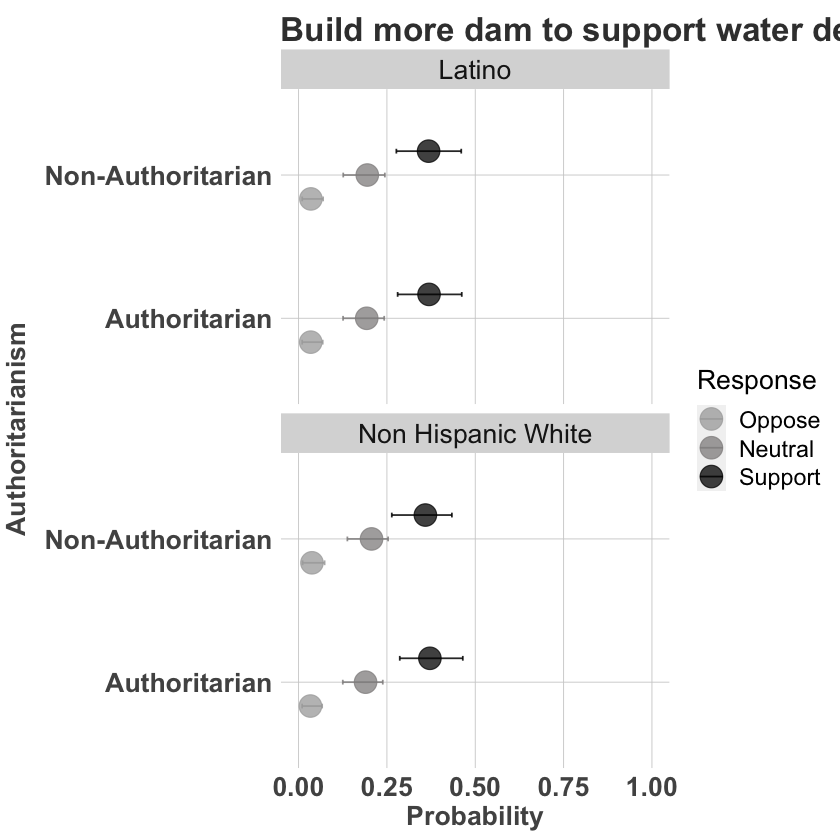

In [131]:
createPlot(thesisData, waterDams, "Build more dam to support water demands")
ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/water2.png", width = 8, height = 8, dpi = 300)


In [132]:
head(thesisData)

,X,rid,mean,lower,upper,auth1,auth2,auth3,auth4,authoritarianism,...,rr,moral_individualism,individualism,ideology,gender,party3,caseid,age,gen,authScaled
,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<chr>,<dbl>
1,1,1237524981,0.1253095,-1.3842783,1.5730996,1,0,1,0,0.50,...,0.0000,0.9375,0.15,1,Female,1,1237524981,43,Gen X,0.50423685
2,2,1238623187,-0.4055693,-1.8384456,1.0395513,0,0,0,1,0.25,...,0.6875,0.2500,0.45,2,Female,1,1238623187,53,Gen X,0.27572721
3,3,1239703947,-0.9952612,-2.6596056,0.5228655,0,0,0,0,0.00,...,0.0625,0.1250,0.20,1,Male,NA,1239703947,73,Boomer,0.02190225
4,4,1241042843,-0.9984238,-2.5772409,0.5269997,0,0,0,0,0.00,...,0.1250,0.3750,0.40,4,Female,2,1241042843,65,Boomer,0.02054097
5,5,1247946517,0.6850764,-0.7559359,2.1946961,1,1,1,0,0.75,...,0.6250,0.3750,0.50,5,Male,3,1247946517,83,Greatest,0.74518101
6,6,1248601193,-1.0099308,-2.5966724,0.4714263,0,0,0,0,0.00,...,0.0000,0.6250,0.20,2,Female,1,1248601193,35,Millenial,0.01558793


# Comparable Effects

Authoritarianism certainly shapes domestic policy attitudes. The question is whether the relationship between authoritarianism and domestic policy attitudes is different for Latinos. The results reported here suggest otherwise. The relationship between authoritarianism and domestic policy attitudes is similar for Latinos and Non Hispanic Whites. Here are some additional comparisons -- individualism, moral indidividualism, and racial resentment. Moral individualism is measured first with the question of who one most trusts: 

* Religion or religious leaders
* My family
* Science, scientists, or experts in the field Ateacher
* What the public generally thinks is right
* A good friend or friends


This is followed with questions like "Nobody, not even \<INSERT FROM ABOVE\>, can decide what is right or wrong, except for me? You can locate the additional items that make up this scale in the codebook.

In [168]:
# Predict moral individualism
# Generate the right kdin of figure

linear_model <- brm(
    formula = generate_formula(DV = "rr"),
    data = thesisData,
    # family = cumulative(),
    chains = 2,
    cores = 6,
    seed = 1234,
    iter = 4000
  )

Compiling Stan program...



Start sampling



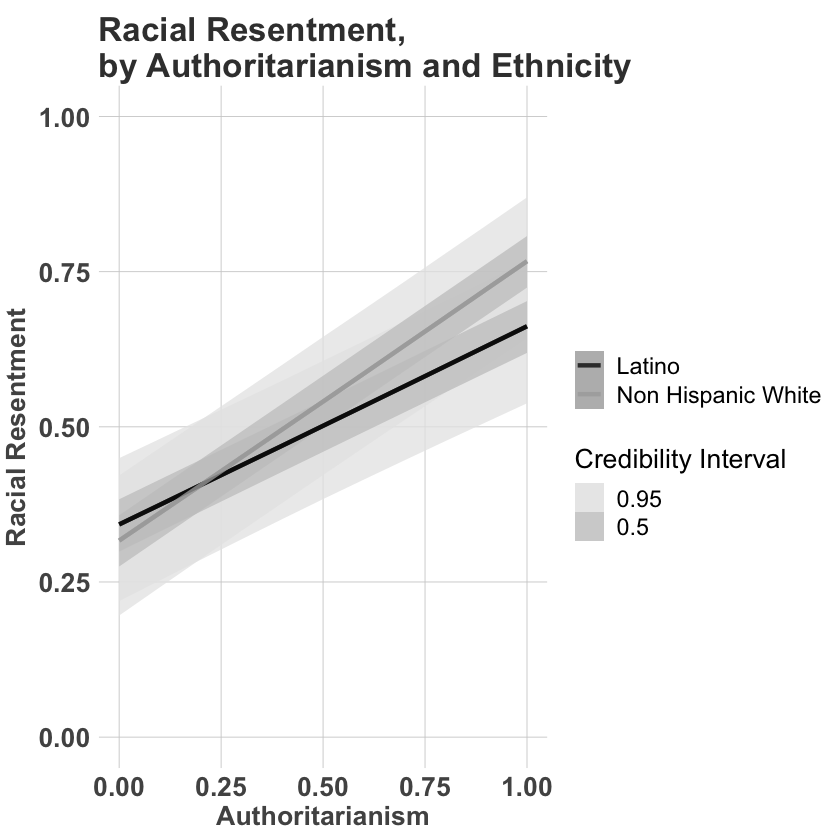

In [169]:
    thesisData %>%
    data_grid(
      gender = c("Male", "Female"), white = c(0,1), other = 0, black = 0,
      college = mean(college), income = mean(income),
      gen = c("Greatest", "Boomer", "Gen X", "Millenial"),
      latino = c(0, 1), authScaled = seq_range(authScaled, n = 11)
    ) %>%
    add_epred_draws(linear_model) %>%
    group_by(authScaled, latino) %>%
    mutate(latino = ifelse(latino == 0, "Non Hispanic White", "Latino")) %>%
        # Compare Two Groups

        filter(latino == "Latino" | white == 1) %>%
      ggplot(aes(
        x = authScaled,
        group = latino,
        color = as.factor(latino),
        y = .epred
      )) +

      stat_lineribbon(.width = c(0.95, 0.50), alpha = 0.75 )+
      scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2)) +
      ggtheme +
            ggtitle("Racial Resentment,\nby Authoritarianism and Ethnicity") +
              scale_y_continuous("Racial Resentment", limits = c(0, 1)) +
              scale_x_continuous("Authoritarianism") +
                    scale_colour_manual(name = "", values = c("black", "darkgrey"))

ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/rr.png", width = 8, height = 8, dpi = 300)



Compiling Stan program...

Start sampling



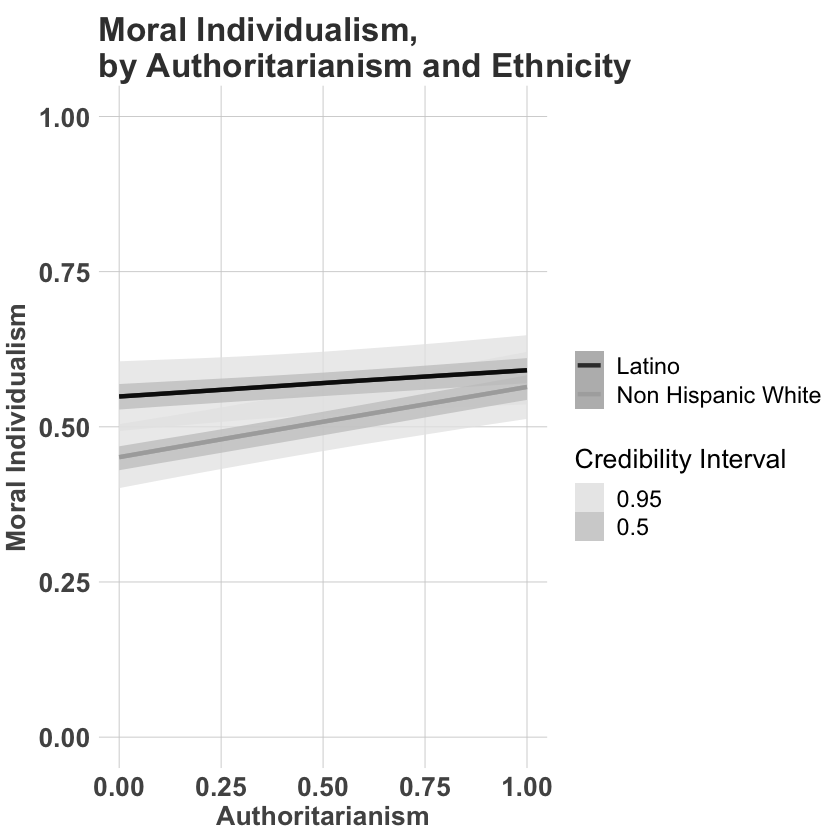

In [170]:
linear_model <- brm(
  formula = generate_formula(DV = "moral_individualism"),
  data = thesisData,
  # family = cumulative(),
  chains = 2,
  cores = 6,
  seed = 1234,
  iter = 4000
)

    thesisData %>%
      data_grid(
        gender = c("Male", "Female"), white = c(0, 1), other = 0, black = 0,
        college = mean(college), income = mean(income),
        gen = c("Greatest", "Boomer", "Gen X", "Millenial"),
        latino = c(0, 1), authScaled = seq_range(authScaled, n = 11)
      ) %>%
      add_epred_draws(linear_model) %>%
      group_by(authScaled, latino) %>%
      mutate(latino = ifelse(latino == 0, "Non Hispanic White", "Latino")) %>%
      # Compare Two Groups

      filter(latino == "Latino" | white == 1) %>%
      ggplot(aes(
        x = authScaled,
        group = latino,
        color = as.factor(latino),
        y = .epred
      )) +
      stat_lineribbon(.width = c(0.95, 0.50), alpha = 0.75) +
      scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2)) +
      ggtheme +
      ggtitle("Moral Individualism,\nby Authoritarianism and Ethnicity") +
      scale_y_continuous("Moral Individualism", limits = c(0, 1)) +
      scale_x_continuous("Authoritarianism") +
      scale_colour_manual(name = "", values = c("black", "darkgrey"))

Compiling Stan program...

Start sampling



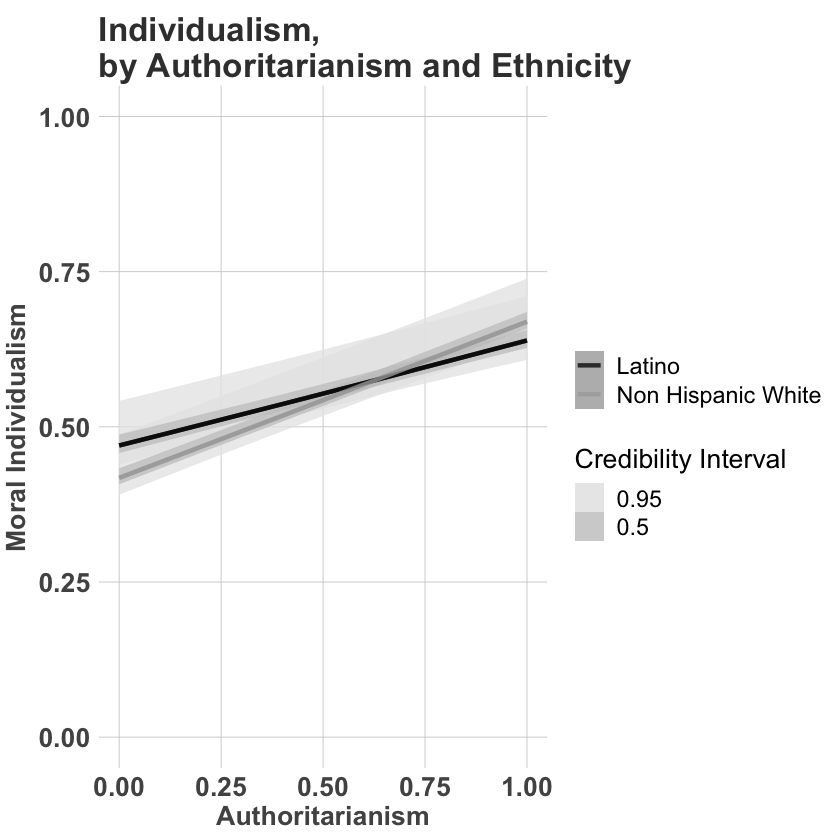

In [171]:
linear_model <- brm(
  formula = generate_formula(DV = "individualism"),
  data = thesisData,
  # family = cumulative(),
  chains = 2,
  cores = 6,
  seed = 1234,
  iter = 4000
)

thesisData %>%
  data_grid(
    gender = c("Male", "Female"), white = c(0, 1), other = 0, black = 0,
    college = mean(college), income = mean(income),
    gen = c("Greatest", "Boomer", "Gen X", "Millenial"),
    latino = c(0, 1), authScaled = seq_range(authScaled, n = 11)
  ) %>%
  add_epred_draws(linear_model) %>%
  group_by(authScaled, latino) %>%
  mutate(latino = ifelse(latino == 0, "Non Hispanic White", "Latino")) %>%
  # Compare Two Groups

  filter(latino == "Latino" | white == 1) %>%
  ggplot(aes(
    x = authScaled,
    group = latino,
    color = as.factor(latino),
    y = .epred
  )) +
  stat_lineribbon(.width = c(0.95, 0.50), alpha = 0.75) +
  scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2)) +
  ggtheme +
  ggtitle("Individualism,\nby Authoritarianism and Ethnicity") +
  scale_y_continuous("Moral Individualism", limits = c(0, 1)) +
  scale_x_continuous("Authoritarianism") +
  scale_colour_manual(name = "", values = c("black", "darkgrey"))

In [151]:
partyID <- brm(
  formula = generate_formula(DV = "party3"),
  data = thesisData,
  family = categorical(),
  chains = 2,
  cores = 6,
  seed = 1234,
  iter = 4000
)

ggtheme <- theme(
  plot.title = element_text(face = "bold", hjust = 0, vjust = 0, colour = "#3C3C3C", size = 20),
  axis.text.x = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.text.y = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.title = element_text(size = 16, colour = "#535353", face = "bold"),
  axis.title.y = element_text(size = 16, colour = "#535353", face = "bold", vjust = 1.5),
  axis.ticks = element_blank(),
  strip.text.x = element_text(size = 16),
  panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
  panel.background = element_rect(fill = "white"),
  legend.text = element_text(size = 14),
  legend.title = element_text(size = 16)
)



Warning message:
"Rows containing NAs were excluded from the model."


Compiling Stan program...

Start sampling



Latinos and Non Hispanic Whites express their authoritarian preferences in remarkably similar ways. However, what is noteworthy is how "politicized" authoritarianism is among Non Hispanic Whites. The relationship between authoritarianism with party identification, ideology and voting is stronger for Non Hispanic Whites than for Latinos. This is consistent with the idea that authoritarianism is a more salient political identity; it also describes why support for Trump among Latinos is increasing. The policy implications of authoritarianism are the same; though Latino authoritarians have not mobilized in favor of the GOP. 

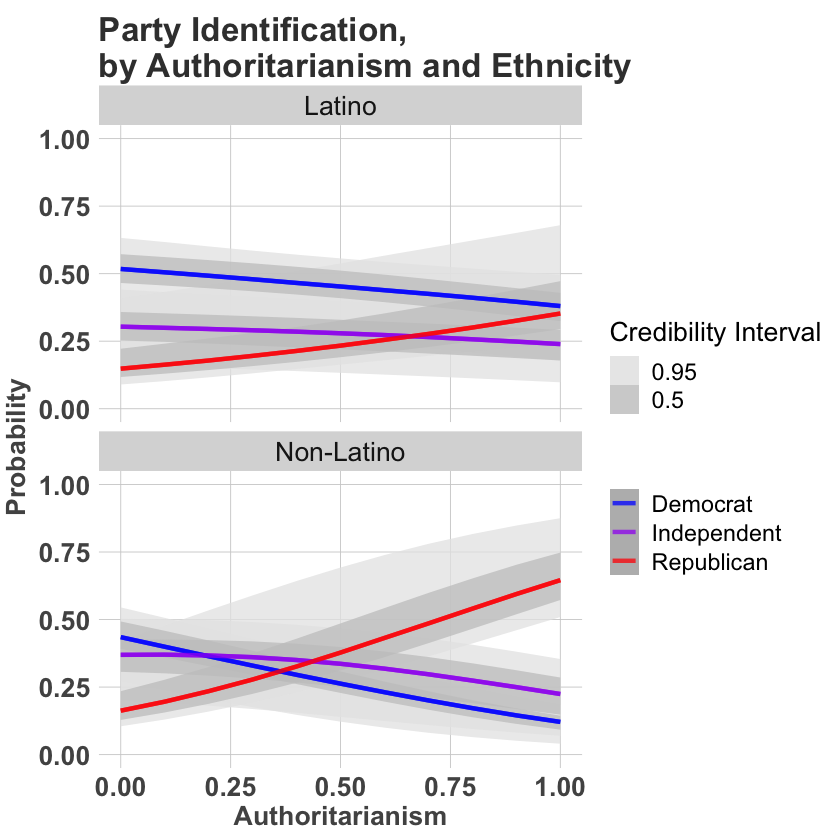

In [200]:
library(ggplot2)
library(simplecolors)
thesisData %>%
  data_grid(
    gender = c("Male", "Female"), white = c(0, 1), other = 0, black = 0,
    college = mean(college), income = mean(income),
    gen = c("Greatest", "Boomer", "Gen X", "Millenial"),
    latino = c(0, 1), authScaled = seq_range(authScaled, n = 11)
  ) %>%
  add_epred_draws(partyID) %>%
  mutate(latino = as.character(ifelse(latino == 0, "Non-Latino", "Latino"))) %>%
  filter(latino == "Latino" | white == 1) %>%

  mutate(party3 = case_when(
    .category == 1 ~ "Democrat",
    .category == 2 ~ "Independent",
    .category == 3 ~ "Republican",
    TRUE ~ "NA"
  )) %>%
  group_by(party3, authScaled, latino) %>%
  ggplot(aes(
    x = authScaled,
    group = party3,
    color = as.factor(party3),
    y = .epred
  )) +
  facet_wrap(~latino, nrow = 3) +
  stat_lineribbon(.width = c(0.95, 0.50), alpha = 0.75) +
  scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2)) +
  ggtheme +
  ggtitle("Party Identification,\nby Authoritarianism and Ethnicity") +
  scale_y_continuous("Probability", limits = c(0, 1)) +
  scale_x_continuous("Authoritarianism") +
  scale_colour_manual(name = "", values = c("blue", "purple","red"))
ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/pid.png", width = 8, height = 8, dpi = 300)

Again, the relationships are similar, with a muted effect among Latinos, particularly at the low end of authoritarianism. Non-authoritarians are more Independent, and less likely to identify as Republican. Likewise, among Latinos, authoritarians are more likely than non-authoritarians to align with the Democratic Party.

In [173]:
voteTrump <- brm(
  formula = generate_formula(DV = "trump_vote"),
  data = thesisData,
  family = bernoulli(),
  chains = 2,
  cores = 6,
  seed = 1234,
  iter = 4000
)

Warning message:
"Rows containing NAs were excluded from the model."
Compiling Stan program...



Start sampling



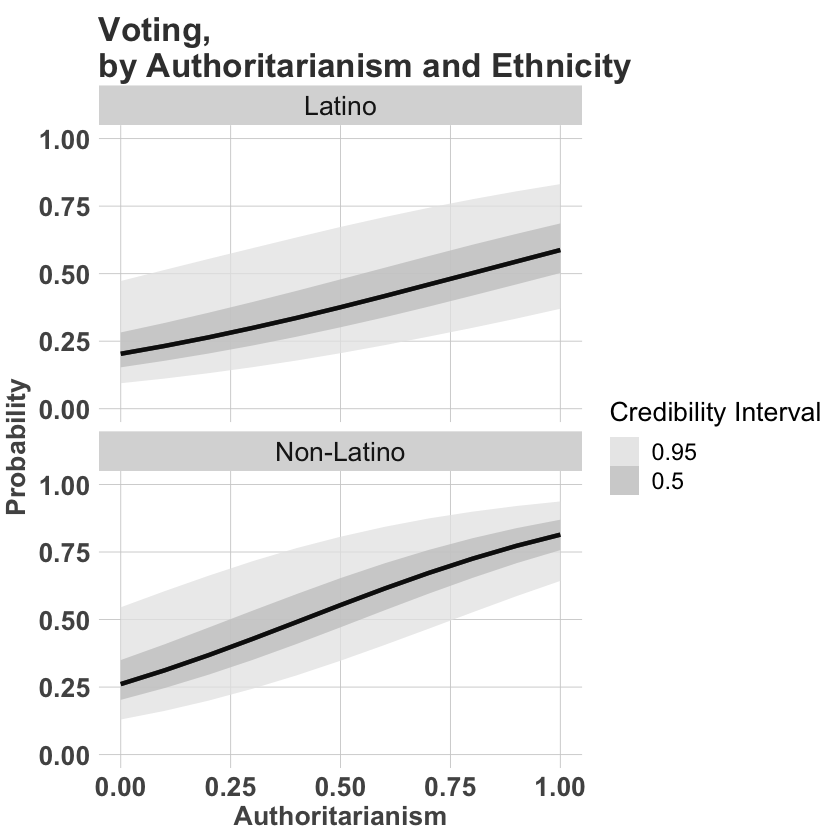

In [201]:
library(ggplot2)
library(simplecolors)
thesisData %>%
  data_grid(
    gender = c("Male", "Female"), white = c(0, 1), other = 0, black = 0,
    college = mean(college), income = mean(income),
    gen = c("Greatest", "Boomer", "Gen X", "Millenial"),
    latino = c(0, 1), authScaled = seq_range(authScaled, n = 11)
  ) %>%
  add_epred_draws(voteTrump) %>%
  mutate(latino = as.character(ifelse(latino == 0, "Non-Latino", "Latino"))) %>%
  group_by(authScaled, latino) %>%
  ggplot(aes(
    x = authScaled,
    # group = latino,
    # color = as.factor(latino),
    y = .epred
  )) +
  facet_wrap(~latino, nrow = 2) +
  stat_lineribbon(.width = c(0.95, 0.50), alpha = 0.75) +
  scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2)) +
  ggtheme +
  ggtitle("Voting,\nby Authoritarianism and Ethnicity") +
  scale_y_continuous("Probability", limits = c(0, 1)) +
  scale_x_continuous("Authoritarianism") +
  scale_colour_manual(name = "", values = c("black", "darkgrey"))
# ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/pid.png", width = 8, height = 8, dpi = 300)

In [202]:

dat = thesisData %>%
  mutate(ideo3 = case_when(
    ideology %in% c(1, 2) ~ "Liberal",
    ideology == 3 ~ "Moderate",
    ideology %in% c(4, 5) ~ "Conservative",
    TRUE ~ NA))

ideology <- brm(
  formula = generate_formula(DV = "ideo3"),
  data = dat,
  family = categorical(),
  chains = 2,
  cores = 6,
  seed = 1234,
  iter = 4000
)




Warning message:
"Rows containing NAs were excluded from the model."


Compiling Stan program...

Start sampling



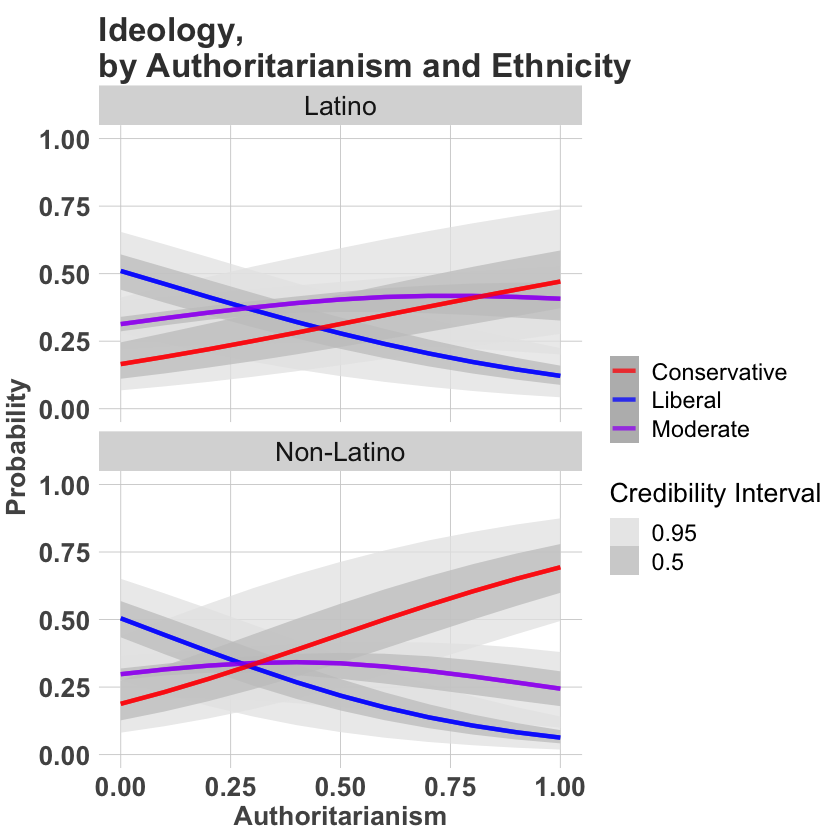

In [203]:
library(ggplot2)
library(simplecolors)
thesisData %>%
  data_grid(
    gender = c("Male", "Female"), white = c(0, 1), other = 0, black = 0,
    college = mean(college), income = mean(income),
    gen = c("Greatest", "Boomer", "Gen X", "Millenial"),
    latino = c(0, 1), authScaled = seq_range(authScaled, n = 11)
  ) %>%
  add_epred_draws(ideology) %>%
  mutate(latino = as.character(ifelse(latino == 0, "Non-Latino", "Latino"))) %>%
  filter(latino == "Latino" | white == 1) %>%
  mutate(ideo = .category ) %>%
  group_by(ideo, authScaled, latino) %>%
  ggplot(aes(
    x = authScaled,
    group = ideo,
    color = as.factor(ideo),
    y = .epred
  )) +
  facet_wrap(~latino, nrow = 3) +
  stat_lineribbon(.width = c(0.95, 0.50), alpha = 0.75) +
  scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2)) +
  ggtheme +
  ggtitle("Ideology,\nby Authoritarianism and Ethnicity") +
  scale_y_continuous("Probability", limits = c(0, 1)) +
  scale_x_continuous("Authoritarianism") +
  scale_colour_manual(name = "", values = c("red", "blue", "purple"))
ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/ideo.png", width = 8, height = 8, dpi = 300)

In [207]:
latino <-
  brm(
    authScaled ~
    latino + white + party3 + latino:party3,
    # family = cumulative(),
    data = thesisData,
    chains = 3,
    cores = 6,
    seed = 1234,
    iter = 1000
  )

Warning message:
"Rows containing NAs were excluded from the model."


Compiling Stan program...

Start sampling



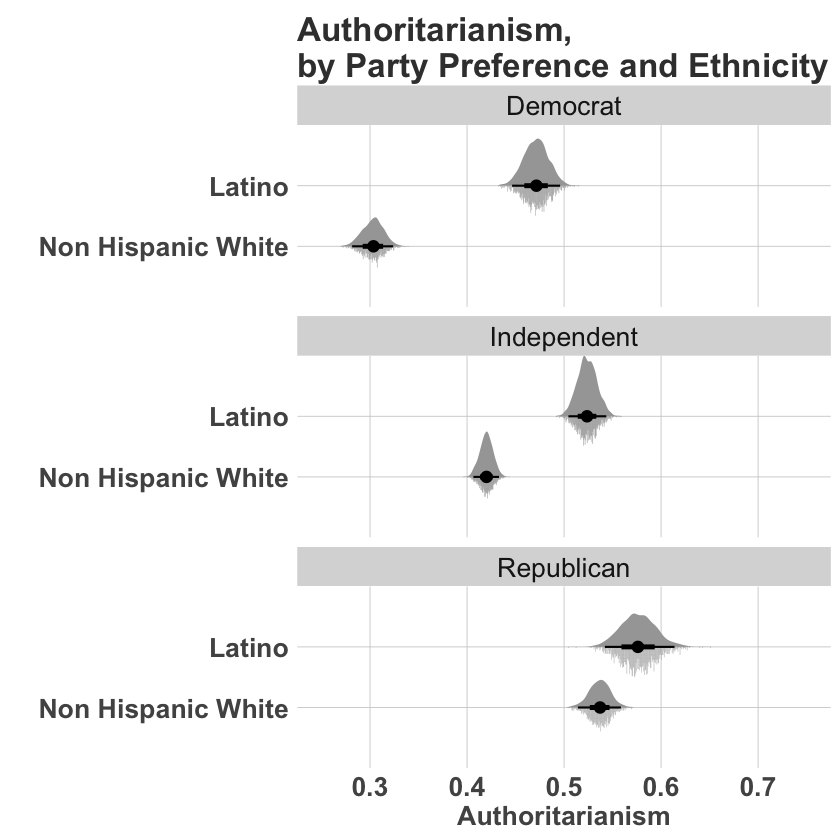

In [242]:
library(ggplot2)
library(simplecolors)
thesisData %>%
  data_grid(
    white = c(0,1),
    latino = c(0, 1),
    party3 = c(1,2,3 ),
  ) %>%
  add_epred_draws(latino) %>%
  mutate(latino = as.character(ifelse(latino == 0, "Non Hispanic White", "Latino"))) %>%

  filter(latino == "Latino" | white == 1) %>%
    mutate(party3 = case_when(
      party3 == 1 ~ "Democrat",
      party3 == 2 ~ "Independent",
      party3 == 3 ~ "Republican",
      TRUE ~ "NA"
    )) %>%


    ggplot(aes(
      x = .epred, y = as.factor(latino),
    )) +
    facet_wrap(~party3, nrow = 3) +
    stat_slab(aes(thickness = stat(pdf * n)), scale = 1) +
      stat_dotsinterval(side = "bottom", scale = 0.5, slab_size = .001) +
      scale_fill_brewer(palette = "Set2") +
  ggtheme +
  # Format the grid
  ggtitle("Authoritarianism,\nby Party Preference and Ethnicity") +
  scale_x_continuous("Authoritarianism", limits = c(0.25, 0.75)) +
  scale_y_discrete("", limits = rev) +
  theme(legend.position = "bottom")


ggsave("/Users/Chris/Dropbox/masterData/Western_States/git/westernStates/Honors Thesis/images/auth.png", width = 8, height = 8, dpi = 300)




# Supplementary Materials

In [205]:
twopldif <- bf(
  response ~ exp(logalpha) * eta,
  eta ~ 1 + (1 + latino | i | item) + (1 | rid),
  logalpha ~ 1 + (1 | i | item),
  nl = TRUE
)

prior2pl <-
  prior("normal(0, 5)", class = "b", nlpar = "eta") +
  prior("normal(0, 1)", class = "b", nlpar = "logalpha") +
  prior("constant(1)", class = "sd", group = "rid", nlpar = "eta") +
  prior("normal(0, 3)", class = "sd", group = "item", nlpar = "eta") +
  prior("normal(0, 1)", class = "sd", group = "item", nlpar = "logalpha")


fit2pldif <- brm(
  formula = twopldif,
  data = df,
  family = brmsfamily("bernoulli", "logit"),
  prior = prior2pl,
  iter = 2000,
  warmup = 1000,
  chains = 4,
  cores = 9,
  control = list(adapt_delta = 0.99,  max_treedepth = 15),
  refresh = 0
)
save(fit2pldif, file = "fit2pldif.rda")

Warning message:
"Rows containing NAs were excluded from the model."


Compiling Stan program...

Start sampling



In [144]:
b <-
  brm(
    rr ~
      # Fixed
      authoritarianism + married +
      college + income + christian +
      post_call + uncertainty + latino +
      authoritarianism:latino +
      authoritarianism:black,
    # family = cumulative(),
    data = dat,
    chains = 3,
    cores = 6,
    seed = 1234,
    iter = 1000
  )


Warning message:
"Rows containing NAs were excluded from the model."
Compiling Stan program...

Start sampling



Latino authoritarians show different behavior -- often not expressing their authoritarian attitudes in clear political directions. This is clear when we look at a variety of issues, from gun control, to immigration, to water use and conservation, ideology, and partisanship. The authoritarian - non-authoritarian divide is markedly more pronounced among Whites, relative to Latinos or other racial and ethnic groups. This tendency is also pronounced when we look at party identification. Authoritarianism is more weakly expressed meaning latino authoritarians have not necessarily sorted into the parties -- at least in the West -- as opposed to Whites. 

